# Preserving (non-NaN) missing values with safeguards

In this example, we compare how two lossy compressors (ZFP, SZ3, and SPERR) handle missing values that are *not* encoded as NaNs. We compress a single time step of the energy release component metric based on satellite observations. The data is on an unstructured grid and contains missing values over sea. Finally, we apply safeguards to guarantee that special missing values are preserved.

Missing values are often encoded in GRIB files as the value `9999`. Since tools like `cfgrib` hide this detail and replace missing values with NaNs when loading the data, we manually read in the GRIB file using `eccodes` to observe the non-NaN missing values.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
import copy
from pathlib import Path

import earthkit.plots
import eccodes
import matplotlib as mpl
import numpy as np
from earthkit.plots.resample import Interpolate
from matplotlib import pyplot as plt
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_wasm_sperr import Sperr
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_zfp_classic import ZfpClassic
from numcodecs_zero import ZeroCodec

In [3]:
data = Path("data") / "cems-ercnfdr" / "data.grib"

In [4]:
with data.open("rb") as f:
    gid = eccodes.codes_grib_new_from_file(f)
    grib_keys = []
    it = eccodes.codes_keys_iterator_new(gid)
    while eccodes.codes_keys_iterator_next(it):
        grib_keys.append(eccodes.codes_keys_iterator_get_name(it))
    eccodes.codes_keys_iterator_delete(it)
    eccodes.codes_release(gid)

In [5]:
with data.open("rb") as f:
    gid = eccodes.codes_grib_new_from_file(f)
    (long_name,) = eccodes.codes_get_array(gid, "name", ktype=str)
    (year,) = eccodes.codes_get_array(gid, "year")
    (month,) = eccodes.codes_get_array(gid, "month")
    (day,) = eccodes.codes_get_array(gid, "day")
    (hour,) = eccodes.codes_get_array(gid, "hour")
    (minute,) = eccodes.codes_get_array(gid, "minute")
    (missing_value,) = eccodes.codes_get_array(gid, "missingValue")
    latitudes = eccodes.codes_get_array(gid, "latitudes")
    longitudes = eccodes.codes_get_array(gid, "longitudes")
    ercnfdr = eccodes.codes_get_array(gid, "values")
    eccodes.codes_release(gid)

In [6]:
missing_value

np.int64(9999)

## Compressing water vapour path with lossy compressors and safeguards

We configure each compressor with an absolute error bound of 1, the step size betweent the discrete metric values.

In [7]:
eb_abs = 1

In [8]:
zfp = ZfpClassic(mode="fixed-accuracy", tolerance=eb_abs)

ercnfdr_zfp_enc = zfp.encode(ercnfdr)
ercnfdr_zfp = zfp.decode(ercnfdr_zfp_enc)
ercnfdr_zfp_cr = ercnfdr.nbytes / ercnfdr_zfp_enc.nbytes

In [9]:
sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

ercnfdr_sz3_enc = sz3.encode(ercnfdr)
ercnfdr_sz3 = sz3.decode(ercnfdr_sz3_enc)
ercnfdr_sz3_cr = ercnfdr.nbytes / ercnfdr_sz3_enc.nbytes

In [10]:
sperr = Sperr(mode="pwe", pwe=eb_abs)

ercnfdr_sperr_enc = sperr.encode(ercnfdr)
ercnfdr_sperr = sperr.decode(ercnfdr_sperr_enc)
ercnfdr_sperr_cr = ercnfdr.nbytes / ercnfdr_sperr_enc.nbytes

## Compressing water vapour path using the safeguards-wrapped lossy compressors

We configure the safeguards to preserve the special missing value, so that missing values are preserved and no non-missing values take on the special value, and to preserve an absolute error bound of 1.

In [11]:
ercnfdr_sg = dict()
ercnfdr_sg_cr = dict()

for codec in [
    ZeroCodec(),
    zfp,
    sz3,
    sperr,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(kind="eb", type="abs", eb=eb_abs),
            dict(kind="same", value=missing_value, exclusive=True),
        ],
    )

    ercnfdr_sg_enc = sg.encode(ercnfdr)
    ercnfdr_sg[codec.codec_id] = sg.decode(ercnfdr_sg_enc)
    ercnfdr_sg_cr[codec.codec_id] = ercnfdr.nbytes / np.asarray(ercnfdr_sg_enc).nbytes

## Visual comparison of the decompressed missing values

Since ZFP, SZ3, and SPERR have no knowledge of the special missing value, the large magnitude of `9999` bleeds into surrounding grid cells and some missing values have large non-missing-value values.

In [12]:
old_scale_dashes = mpl.lines._scale_dashes


def scale_dashes(offset, dashes, lw):
    if lw == 0:
        return offset, dashes
    return old_scale_dashes(offset, dashes, lw)


mpl.lines._scale_dashes = scale_dashes

In [13]:
def plot_ercnfdr(
    data: np.ndarray,
    cr,
    chart,
    title,
    compressed=False,
):
    x = longitudes
    y = latitudes
    z = np.where(data == missing_value, np.nan, data)

    source = earthkit.plots.sources.get_source(x=x, y=y, z=z)
    style = copy.deepcopy(earthkit.plots.styles.auto.guess_style(source))
    levels = np.linspace(-1, 81, 22)
    style._levels = earthkit.plots.styles.levels.Levels(levels)

    interpolate = Interpolate()

    x, y, z = interpolate.apply(
        x=x,
        y=y,
        z=z,
        source_crs=source.crs,
        target_crs=chart.crs,
    )

    chart.pcolormesh(
        x=x,
        y=y,
        z=z,
        style=style,
        norm=mpl.colors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True),
        rasterized=True,
    )
    chart.ax.set_rasterization_zorder(-10)

    chart.coastlines()
    chart.borders()
    chart.gridlines()

    if compressed:
        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{e}}}})$={np.amax(np.abs(data - ercnfdr)):.02}"
        )
    else:
        chart.title(title)

    if compressed:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

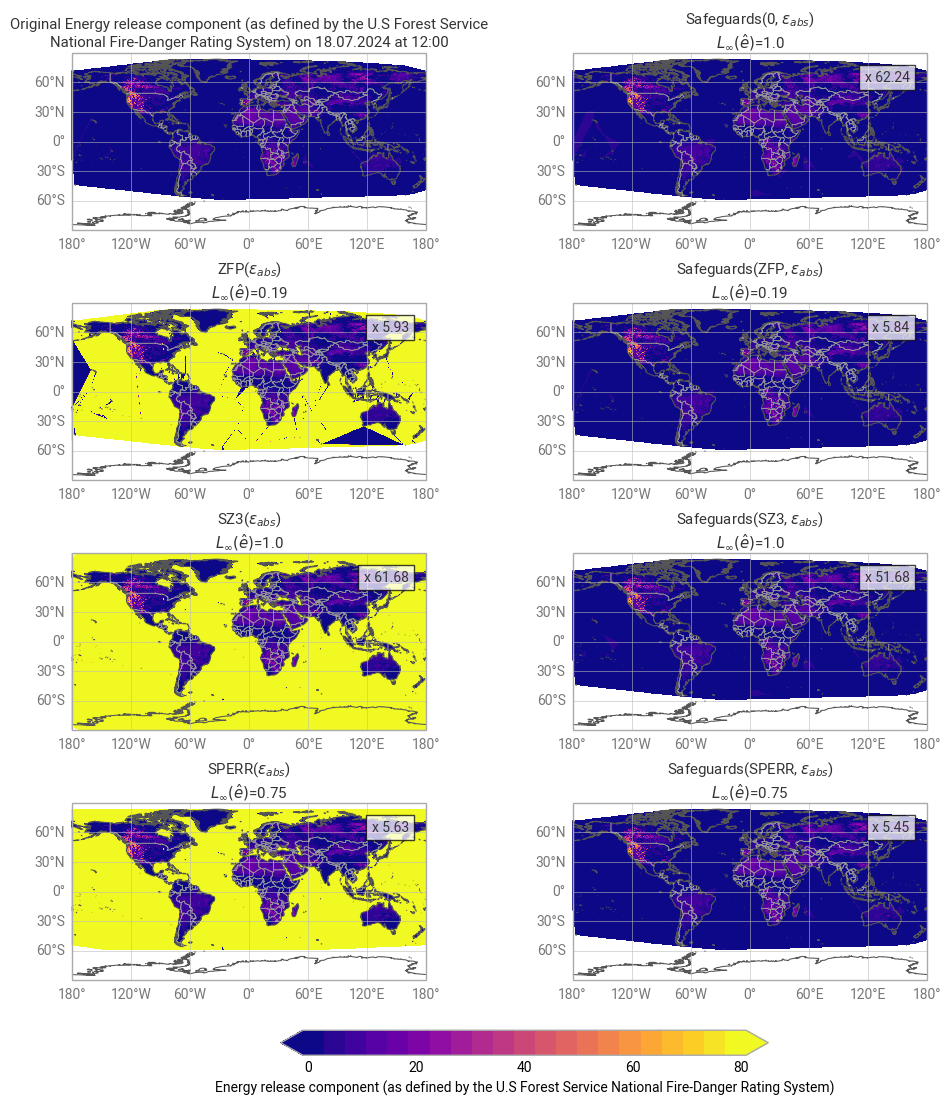

In [14]:
fig = earthkit.plots.Figure(
    size=(10, 10),
    rows=4,
    columns=2,
)

plot_ercnfdr(
    ercnfdr,
    1.0,
    fig.add_map(0, 0),
    f"Original {long_name} on {day:02}.{month:02}.{year} at {hour:02}:{minute:02}",
)
plot_ercnfdr(
    ercnfdr_zfp,
    ercnfdr_zfp_cr,
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}$)",
    compressed=True,
)
plot_ercnfdr(
    ercnfdr_sz3,
    ercnfdr_sz3_cr,
    fig.add_map(2, 0),
    r"SZ3($\epsilon_{{abs}}$)",
    compressed=True,
)
plot_ercnfdr(
    ercnfdr_sperr,
    ercnfdr_sperr_cr,
    fig.add_map(3, 0),
    r"SPERR($\epsilon_{{abs}}$)",
    compressed=True,
)

plot_ercnfdr(
    ercnfdr_sg["zero"],
    ercnfdr_sg_cr["zero"],
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{abs}}$)",
    compressed=True,
)
plot_ercnfdr(
    ercnfdr_sg["zfp-classic.rs"],
    ercnfdr_sg_cr["zfp-classic.rs"],
    fig.add_map(1, 1),
    r"Safeguards(ZFP, $\epsilon_{{abs}}$)",
    compressed=True,
)
plot_ercnfdr(
    ercnfdr_sg["sz3.rs"],
    ercnfdr_sg_cr["sz3.rs"],
    fig.add_map(2, 1),
    r"Safeguards(SZ3, $\epsilon_{{abs}}$)",
    compressed=True,
)
plot_ercnfdr(
    ercnfdr_sg["sperr.rs"],
    ercnfdr_sg_cr["sperr.rs"],
    fig.add_map(3, 1),
    r"Safeguards(SPERR, $\epsilon_{{abs}}$)",
    compressed=True,
)

ax = plt.axes((0.05, -0.05, 0.95, 0.025))
fig.legend(ax=ax, label=long_name, ticks=np.linspace(0, 80, 5), extend="both")

fig.save("missing.pdf")
fig.show()